# Description

There is three category we have to deal to be able to predict:

**1. Data Preparation which contains the following:**
    1. Missing Values
    2. Skewness in target value (value to predict)
    3. Outliers
    4. Not informative Features
    5. Accurate store_primary_category
    6. Add more relevant features
**2. Modeling**
    1. Choose the best model (No Free Lunch applies)
    2. Model orders/requests which are not in any cluster
**3. Evaluation**

## 1. Data Preparation
I clustered the dataset based on **mark_id** and **store_primary_category**.( This is the main idea)
Based on my research (cell 15 vs cell 27) total delivery duration in seconds has more correlation with features within each cluster, and it makes more sense total delivery duration seconds for the same market_id and tore_primary_category are more correlated.

#### 1 . Missing Values
Missing values are replaced with the median value within each cluster. 

#### 2 . Skewness in the target value
Skewness in the target value in each cluster is much less than overall skewness.

#### 3 . Outliers
Outliers are removed based on the mean and standard deviation of total delivery duration seconds in each cluster.

#### 4. Not informative Features
Features are more informative in each cluster rather than in all dataset. (cell 15 vs cell 27)

#### 5. Accurate store_primary_category
But there is the big problem here, **store_primary_category** varies between different records/requests.
To solve the problem, **store_primary_category** for each restaurant is changed with its max reputation to have a more relevant data.

#### 6. Add more relevant features
The following relative features are added (any other feature is added for debugging):

1. dayofweek: The day of the week which order created at
2. Hours of order: the hour of the day (0-23) which order created at
3. total_onshift_available: As total_busy_dashers: Subset of total_onshift_dashers total_onshift_dashers -total_busy_dashers is added as one feature and replace 0 for negative values. I know total_onshift_dashers and total_busy_dashers might be very noisy as the values are getting from GPS and drivers are moving all the time.
4. Store_id_int: This might not a very good feature (I know! - look at Gini Index) but the idea is the same store should have roughly the same total delivery duration in the same day of week and hour of the day. So I took the last 32bits as one feature.

Also, I used Random Forest's information Gain to rank the importance of features to validate if these features are important.

## 2. Modeling

####    1. Choose the best model (No Free Lunch applies)
I tried different models such as Random Forest, Gradient Boosted Trees, and Adaboost. Random Forests has better performance (RMSE). I think the reason is the total delivery duration seconds has high variance and Random Forest is a good model to reduce variance (I can talk about this over the phone) 
The Random Forest model has:
    number of trees: 100
    max depth: 7

####    2. Model orders/requests which are not in any cluster
To predict total delivery duration seconds for the restaurant with the missing value of **mark_id** or **store_primary_category**, a general model is created (in the production python code). If mark_id and store_primary_category exist but there are few of them to model, dataset is filtered based on mark_id OR store_primary_category.



## 3. Evaluation
I divided data based on time, for example, all orders before 2015-02-17 as train data and the rest for the test data. It does not make sense to shuffle or cross validate because I think it is important to keep the order of the data based on date.


A separate model for each market_id and store_primary_category is generated.
Reason for choosing Random Forests is the high variance in the target values.


## recommendation   to   reduce   delivery   time

1. There is a high variance in total delivery duration in seconds. First, we should find out why there are outliers in this values for some orders. So, I recommend to find the outliers and try to reduce them if it is possible. 

2. There is a gap between total delivery duration seconds and predicted delivery duration seconds. 
    
    As we know:

    Total delivery duration seconds = estimated_order_place_duration + estimated_store_to_consumer_driving_duration + time for driver to pick up and deliver
    We have to find out where this gap is coming from and try to reduce it.
    Basically, assume predicted delivery duration seconds is our expectation time and find why the actual value is total delivery duration seconds.
    
3. (I not sure about this one) It seems there is a big negative correlation between estimated_order_place_duration and order_protocol. Lower order_protocol takes more time. We maybe able to see why some of order_protocl takes more time.


#### Import libraries

In [116]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.metrics import mean_squared_error
from math import sqrt
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from pandas_summary import DataFrameSummary
warnings.filterwarnings('ignore')
import warnings
%matplotlib inline

#### Read Data

In [117]:
filename = 'Data_Science/historical_data.csv'

In [118]:
df = pd.read_csv(filename)

### Data Analysis

In [119]:
DataFrameSummary(df).columns_stats

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
counts,196441,197428,197421,197428,192668,196433,197428,197428,197428,197428,197428,181166,181166,181166,197428,196902
uniques,6,180985,178110,6743,74,7,57,8368,20,2312,2652,172,159,281,98,1336
missing,987,0,7,0,4760,995,0,0,0,0,0,16262,16262,16262,0,526
missing_perc,0.50%,0%,0.00%,0%,2.41%,0.50%,0%,0%,0%,0%,0%,8.24%,8.24%,8.24%,0%,0.27%
types,numeric,categorical,categorical,categorical,categorical,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric,numeric


#### Remove intances without label and convert time to datetime

In [120]:
# Drop NAs in actual_delivery_time column
df = df.dropna(subset=['actual_delivery_time'])

# Convert to datetime
df.created_at = pd.to_datetime(df.created_at)
df.actual_delivery_time = pd.to_datetime(df.actual_delivery_time)

#### Analyze total_delivery_duration_seconds as the target

In [121]:
# total_delivery_duration_seconds
df['total_delivery_duration_seconds'] = (df.actual_delivery_time - df.created_at).dt.total_seconds()

mean                            2908.26
std                             19229.6
variance                    3.69778e+08
min                                 101
max                         8.51686e+06
5%                                 1492
25%                                2104
50%                                2660
75%                                3381
95%                                4872
iqr                                1277
kurtosis                         194653
skewness                        439.701
sum                         5.74151e+08
mad                             879.668
cv                              6.61207
zeros_num                             0
zeros_perc                           0%
deviating_of_mean                     3
deviating_of_mean_perc            0.00%
deviating_of_median                6254
deviating_of_median_perc          3.17%
top_correlations                       
counts                           197421
uniques                            7134


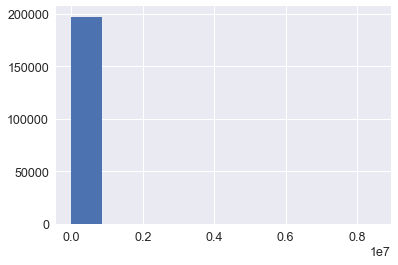

In [122]:
DataFrameSummary(df)['total_delivery_duration_seconds']

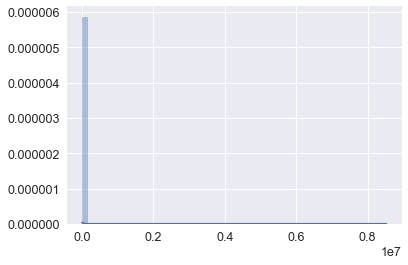

In [123]:
#histogram
sns.distplot(df[['total_delivery_duration_seconds']])

In [124]:
#skewness and kurtosis
print("Skewness: %f" % df['total_delivery_duration_seconds'].skew())
print("Kurtosis: %f" % df['total_delivery_duration_seconds'].kurt())

Skewness: 439.700875
Kurtosis: 194652.786358


{'whiskers': [<matplotlib.lines.Line2D at 0x11700b748>,
 'caps': [<matplotlib.lines.Line2D at 0x1170120b8>,
 'boxes': [<matplotlib.lines.Line2D at 0x11700b5c0>],
 'medians': [<matplotlib.lines.Line2D at 0x117012978>],
 'fliers': [<matplotlib.lines.Line2D at 0x117012dd8>],
 'means': []}

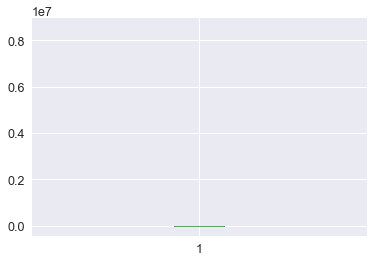

In [125]:
# basic plot
plt.boxplot(df['total_delivery_duration_seconds'])

#### Correlation matrix (heatmap style)

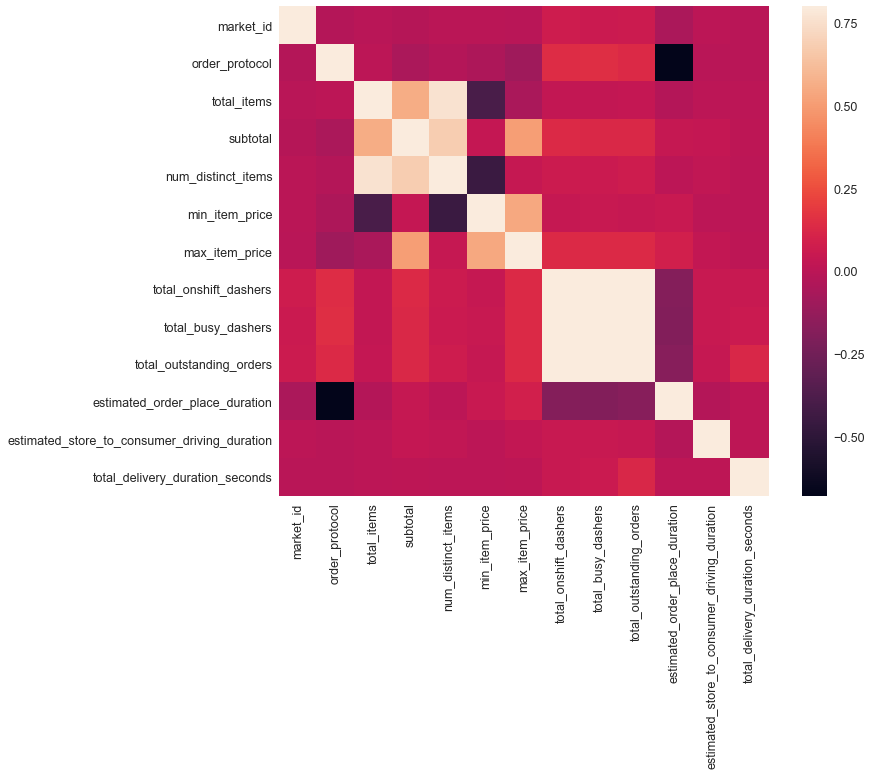

In [126]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

#### correlation matrix (zoomed heatmap style)

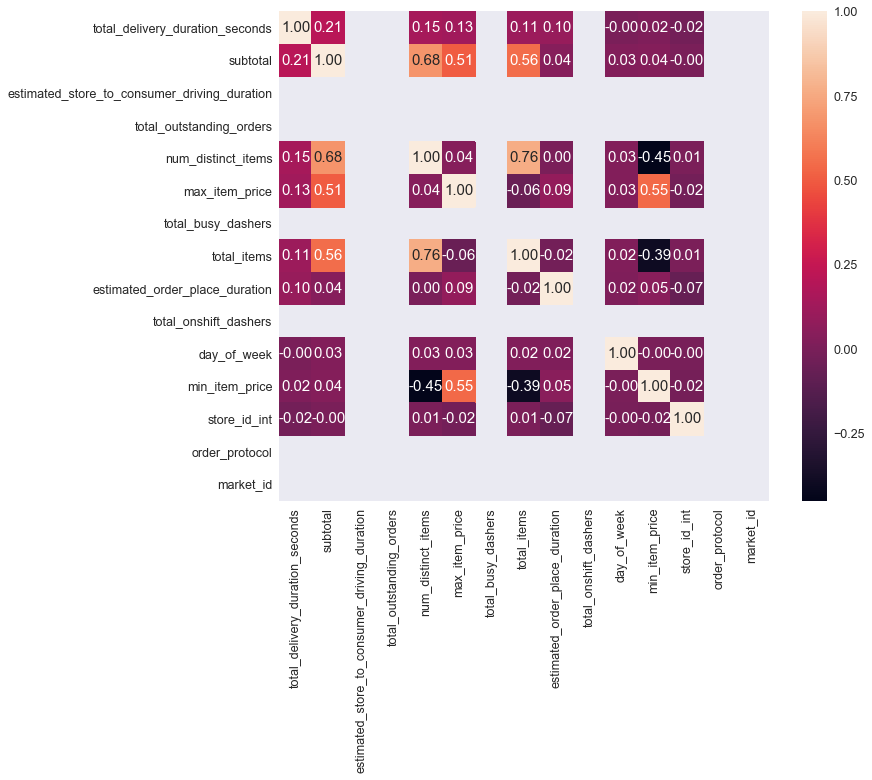

In [147]:
#price correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'total_delivery_duration_seconds')['total_delivery_duration_seconds'].index
cm = np.corrcoef(df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

#### Remove outliers

In [128]:
# Remove outliers
mean = df['total_delivery_duration_seconds'].mean()
std = df['total_delivery_duration_seconds'].std()
outlier_high_range = mean + 2 * std
df[df['total_delivery_duration_seconds'] < outlier_high_range]
df = df[df['total_delivery_duration_seconds'] < outlier_high_range]

#### Best Store primary category

In [129]:
best_store_primary_category_df = df \
    .groupby(['store_primary_category', 'store_id']) \
    .agg({'store_primary_category': 'count'}) \
    .rename(columns={'store_primary_category':'store_primary_category_count'}) \
    .reset_index() \
    .sort_values('store_primary_category_count', ascending=False) \
    .drop_duplicates('store_id') \
    .set_index('store_id')

#### Add new features

In [130]:
## Add the best story categoty
best_store_primary_category_dict = best_store_primary_category_df['store_primary_category'].to_dict()
df['store_primary_category'] = df['store_id'].map(best_store_primary_category_dict).fillna(value = 'other')
## dayofweek
df['day_of_week'] = df['created_at'].dt.dayofweek
## Hours of order
df['hour_of_order'] = df['created_at'].dt.hour
## Store_id_int
df['store_id_int'] = df['store_id'] \
                        .str.slice(0, 8) \
                        .apply(lambda x: int(x, 16))

In [131]:
input_df = df
market_id = 1
label_col_name = 'total_delivery_duration_seconds'

store_primary_category = 'italian'

#   X_train, X_test, y_train, y_test = train_test_split(
#   features_df, label_df, test_size=0.33, random_state=4)

#def randomForestModel(input_df, market_id, store_primary_category):

time_split = input_df['created_at'] < datetime.date(2015, 2, 14)
train_df = input_df[time_split]
test_df = input_df[~time_split]

print('''len train: {},
    len test: {}'''.format(len(train_df), len(test_df)))

len train: 161326,
    len test: 36088


In [132]:
label_col_name = 'total_delivery_duration_seconds'
features_col_name = ['market_id',  \
                     'order_protocol',  \
                     'total_items', \
                     'subtotal',  \
                     'num_distinct_items',  \
                     'min_item_price',  \
                     'max_item_price',  \
                     'total_onshift_dashers',  \
                     'total_busy_dashers',  \
                     'total_outstanding_orders',  \
                     'estimated_order_place_duration',  \
                     'estimated_store_to_consumer_driving_duration',  \
                     'day_of_week',  \
                     'hour_of_order', \
                     'store_id_int']

In [133]:
market_id_filter = train_df.market_id == market_id
store_primary_filter = train_df.store_primary_category == store_primary_category

train_df = train_df[market_id_filter & store_primary_filter]
#train_df.drop(columns = ['best_store_primary_category'], inplace = True)

In [134]:
# Remove NAs
na_replacement_dict = train_df.median().to_dict()

In [135]:
train_df.fillna(na_replacement_dict, inplace = True)

#     if(len(train_df) < 100):
#         return 'null' 

In [136]:
print('Training model ...')
rf_rgr_model = RandomForestRegressor(n_estimators=100,
                                n_jobs=-1,
                                random_state=2,
                                oob_score = True,
                                max_depth=7)

X_train = train_df[features_col_name].values
y_train = train_df[label_col_name].values
print('Done')

Training model ...
Done


In [137]:
test_df = test_df.fillna(na_replacement_dict)

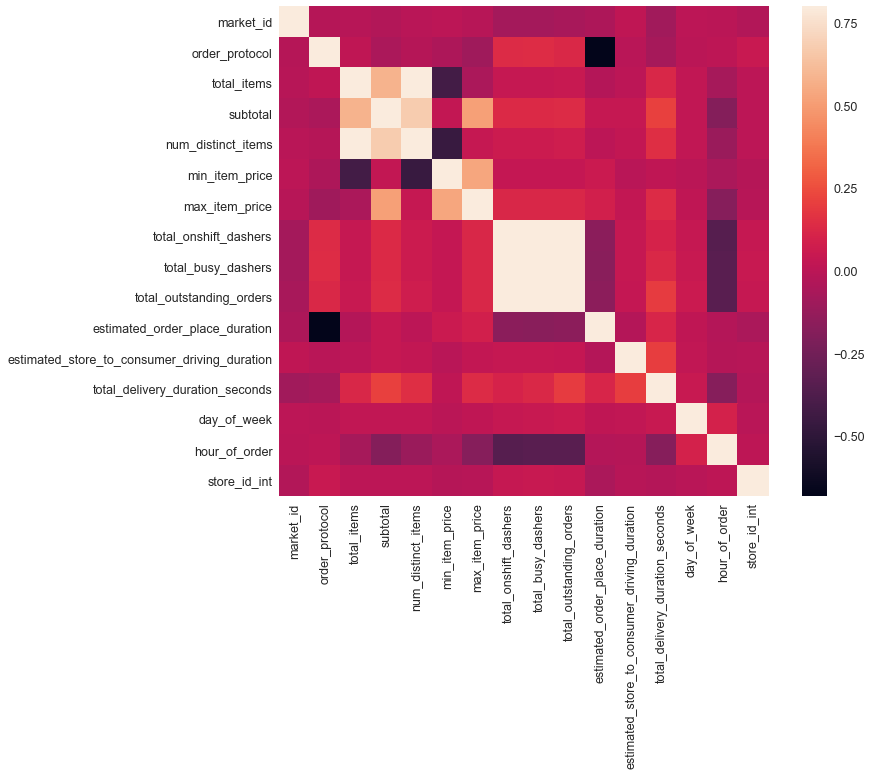

In [138]:
#correlation matrix
corrmat = test_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

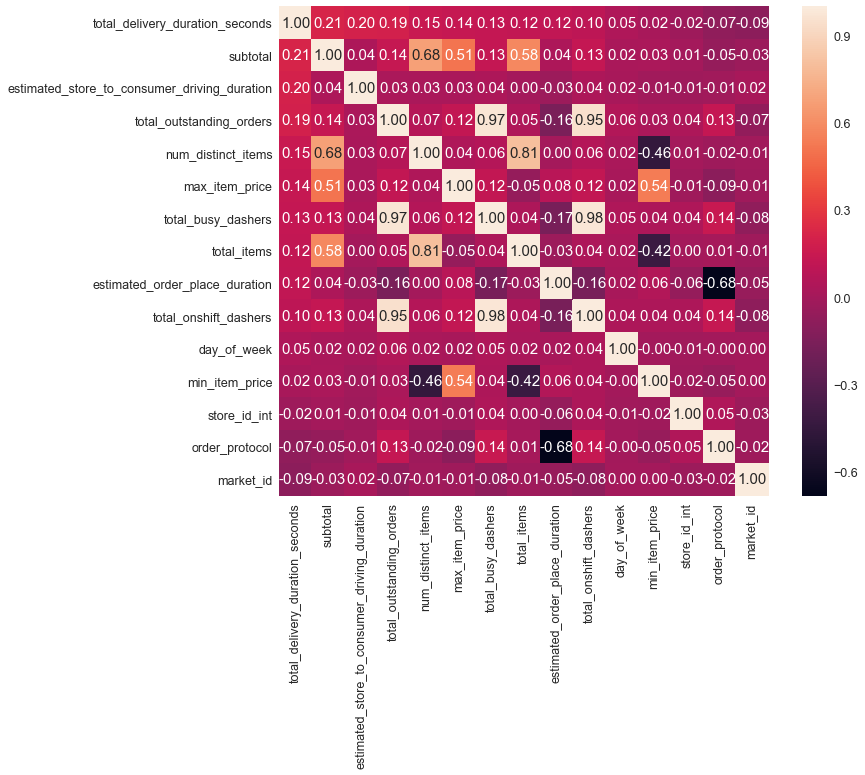

In [146]:
#### correlation matrix (zoomed heatmap style)
#price correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'total_delivery_duration_seconds')['total_delivery_duration_seconds'].index
cm = np.corrcoef(test_df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [102]:
X_test = test_df[features_col_name].values
y_test = test_df[label_col_name].values

In [103]:
rf_rgr_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=2, verbose=0, warm_start=False)

In [104]:
predictions = rf_rgr_model.predict(X_test)

In [105]:
# print("Performace metrics of oob:")
# mtr.roc_auc_score(y_train, rf_rgr_model.oob_prediction_)

print("Root Mean Squared Error Train  :: ", sqrt(mean_squared_error(y_train, rf_rgr_model.predict(X_train))))
print("Root Mean Squared Error Test  :: ", sqrt(mean_squared_error(y_test, rf_rgr_model.predict(X_test))))

Root Mean Squared Error Train  ::  789.252981533473
Root Mean Squared Error Test  ::  1096.804941993944


## Functions

In [106]:
def train_data_feature_generation(df):
    
    #df = input_df
    
    ## Remove intances without label and convert time to datetime
    # Drop NAs in actual_delivery_time column
    df.dropna(subset=['actual_delivery_time'], inplace = True)
    df.dropna(subset=['created_at'], inplace = True)
    # Convert to datetime
    df.created_at = pd.to_datetime(df.created_at)
    df.actual_delivery_time = pd.to_datetime(df.actual_delivery_time)
    # total_delivery_duration_seconds
    df['total_delivery_duration_seconds'] = (df.actual_delivery_time - df.created_at).dt.total_seconds()
    
    ## Best Store primary category
    best_store_primary_category_df = df \
        .groupby(['store_primary_category', 'store_id']) \
        .agg({'store_primary_category': 'count'}) \
        .rename(columns={'store_primary_category':'store_primary_category_count'}) \
        .reset_index() \
        .sort_values('store_primary_category_count', ascending=False) \
        .drop_duplicates('store_id') \
        .set_index('store_id')
    
    ## Add new features
    # Add the best story categoty
    best_store_primary_category_dict = best_store_primary_category_df['store_primary_category'].to_dict()
    df['store_primary_category'] = df['store_id'].map(best_store_primary_category_dict).fillna(value = 'other')

    
    # dayofweek
    df['day_of_week'] = df['created_at'].dt.dayofweek
    # Hours of order
    df['hour_of_order'] = df['created_at'].dt.hour
    # Minutes of order
    df['minutes_of_order'] = df['created_at'].dt.minute
    # Store_id_int
    df['store_id_int'] = df['store_id'] \
                            .str.slice(0, 8) \
                            .apply(lambda x: int(x, 16))
    # total_onshift_available
    df['total_onshift_available'] = df['total_onshift_dashers'] - df['total_busy_dashers']

    # Replace negative with zero
    num = df._get_numeric_data()
    num[num < 0] = 0
    
    return(df)

In [107]:
# median_df = df \
#     .dropna() \
#     .groupby(['market_id', 'store_primary_category']) \
#     .median() \
#     .reset_index()

def median_dict(median_df, market_id, store_primary_category):

    market_id_filter = median_df.market_id == market_id
    store_primary_filter = median_df.store_primary_category == store_primary_category

    return(median_df[market_id_filter & store_primary_filter].to_dict('records')[0])

def na_replacement(df, median_df, market_id, store_primary_category):
    
    na_replacement_dict = median_dict(median_df, market_id, store_primary_category)
    df_na_removed = df.fillna(na_replacement_dict)
    
    return(df_na_removed)

In [108]:
def test_data_feature_generation(df):
    
    # dayofweek
    df['day_of_week'] = df['created_at'].dt.dayofweek
    # Hours of order
    df['hour_of_order'] = df['created_at'].dt.hour
    # Minutes of order
    df['minutes_of_order'] = df['created_at'].dt.minute
    # Store_id_int
    df['store_id_int'] = df['store_id'] \
                            .str.slice(0, 8) \
                            .apply(lambda x: int(x, 16))

    # total_onshift_available
    df['total_onshift_available'] = df['total_onshift_dashers'] - df['total_busy_dashers']
    # Replace negative with zero
    num = df._get_numeric_data()
    num[num < 0] = 0
    
    return(df)

In [109]:
def filter_market_category(df, market_id, store_primary_category):
    
    market_id_filter = df.market_id == market_id
    store_primary_filter = df.store_primary_category == store_primary_category

    return(df[market_id_filter & store_primary_filter])

In [110]:
def random_forest_modeling(train_df, label_col_name, features_col_name):
    
    rf_rgr_model = RandomForestRegressor(n_estimators=100,
                                    n_jobs=-1,
                                    random_state=2,
                                    max_depth=7)

    X_train = train_df[features_col_name].values
    y_train = train_df[label_col_name].values
    
    rf_rgr_model.fit(X_train, y_train)
    
    return(rf_rgr_model)

# def randomForest_tagging(model, test_df, features_col_name):
    
#     X_test = test_df[features_col_name].values
#     return(model.predict(X_test))
    
    

In [111]:
def rf_delivery_duration_estimator(train_df, test_df, \
                                   label_col_name, features_col_name, \
                                   market_id, store_primary_category):
    
    
    market_id_filter = train_df.market_id == market_id
    store_primary_filter = train_df.store_primary_category == store_primary_category

    train_df = train_df[market_id_filter & store_primary_filter]
    
    market_id_filter = test_df.market_id == market_id
    store_primary_filter = test_df.store_primary_category == store_primary_category
    
    test_df = test_df[market_id_filter & store_primary_filter]
    
    train_df = train_data_feature_generation(train_df)
    
    median_dict = train_df\
        .dropna() \
        .median() \
        .to_dict()
    
    train_df = train_df.fillna(median_dict)

    
    mean = train_df['total_delivery_duration_seconds'].mean()
    std = train_df['total_delivery_duration_seconds'].std()
    outlier_high_range = mean + 2 * std

    not_outliers_filter = train_df['total_delivery_duration_seconds'] < outlier_high_range
    train_df = train_df[not_outliers_filter]
    
    
    print('''size train = {} \nsize test = {}'''.format(len(train_df), len(test_df)))
    
    
    test_df = test_data_feature_generation(test_df)
    test_df = test_df.fillna(median_dict)
            
    X_test = test_df[features_col_name].values
    
    X_train = train_df[features_col_name].values
    y_train = train_df[label_col_name].values

    model = RandomForestRegressor(n_estimators=100,
                                  n_jobs=-1,
                                  random_state=3,
                                  max_depth=7)
    
    model.fit(X_train, y_train)
    
    ## Debugging
    # Convert to datetime
    test_df.created_at = pd.to_datetime(test_df.created_at)
    test_df.actual_delivery_time = pd.to_datetime(test_df.actual_delivery_time)

    # total_delivery_duration_seconds
    test_df['total_delivery_duration_seconds'] = (test_df.actual_delivery_time - test_df.created_at).dt.total_seconds()
    y_test = test_df[label_col_name].values
    mean_vec = [np.mean(y_train)] * len(y_test)
    
    print("Root Mean Squared Error Train  :: ", sqrt(mean_squared_error(y_train, model.predict(X_train))))
    print("Root Mean Squared Error Test  :: ", sqrt(mean_squared_error(y_test, model.predict(X_test))))
    print("Root Mean Squared Error with avg  :: ", sqrt(mean_squared_error(y_test, mean_vec)))
    
    feats = {} # a dict to hold feature_name: feature_importance
    
    for feature, importance in zip(features_col_name, model.feature_importances_):
        feats[feature] = importance #add the name/value pair 

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
    #importances.sort_values(by='Gini-importance', ascending=False)
    print(importances.sort_values(by='Gini-importance', ascending=False))


In [112]:
input_df = pd.read_csv(filename)

# Convert to datetime
input_df.created_at = pd.to_datetime(input_df.created_at)
input_df.actual_delivery_time = pd.to_datetime(input_df.actual_delivery_time)

time_split = input_df['created_at'] < datetime.date(2015, 2, 17)
train_df = input_df[time_split]
test_df = input_df[~time_split]

test_df.dropna(subset=['actual_delivery_time'], inplace = True)
test_df.dropna(subset=['created_at'], inplace = True)

print('''len train: {},
    len test: {}'''.format(len(train_df), len(test_df)))

len train: 187369,
    len test: 10059


In [113]:
label_col_name = 'total_delivery_duration_seconds'
features_col_name = ['market_id', \
                     'order_protocol',  \
                     'total_items', \
                     'subtotal',  \
                     'num_distinct_items',  \
                     'min_item_price',  \
                     'max_item_price',  \
                     'total_onshift_dashers',  \
                     'total_busy_dashers',  \
                     'total_onshift_available', \
                     'total_outstanding_orders',  \
                     'estimated_order_place_duration',  \
                     'estimated_store_to_consumer_driving_duration',  \
                     'day_of_week',  \
                     'hour_of_order', \
                     'minutes_of_order', \
                     'store_id_int']

In [114]:
market_id = 1
store_primary_category = 'american'

In [115]:
rf_delivery_duration_estimator(train_df, test_df, \
                               label_col_name, features_col_name, \
                               market_id, store_primary_category)

size train = 4728 
size test = 291
Root Mean Squared Error Train  ::  763.4458837937407
Root Mean Squared Error Test  ::  1132.7237995734588
Root Mean Squared Error with avg  ::  1254.2727576519762
                                              Gini-importance
estimated_store_to_consumer_driving_duration         0.267478
total_onshift_available                              0.146954
subtotal                                             0.092464
total_outstanding_orders                             0.077892
hour_of_order                                        0.076102
max_item_price                                       0.046802
store_id_int                                         0.045188
total_onshift_dashers                                0.044717
order_protocol                                       0.044317
total_busy_dashers                                   0.032324
min_item_price                                       0.031377
minutes_of_order                                     0.031